In [2]:
%matplotlib inline
import pickle

import matplotlib.pyplot as plt
import numpy as np
import os

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import dataset
import numpy as np
import pickle
from cautious_extrapolation.data_paths import DATA_PATHS 
from cautious_extrapolation.utils import get_imagenet_features, kl_divergence_gaussian
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

/home/katie/miniconda3/envs/cifar10/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:

val_dataset = dataset.DatasetVal(DATA_PATHS["nfs"]["SkinLesionPixels"])
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=32, shuffle=True)

ood_dataset = dataset.DatasetTest(DATA_PATHS["nfs"]["SkinLesionPixels"])
ood_loader = torch.utils.data.DataLoader(dataset=ood_dataset, batch_size=32, shuffle=True) 

(1164,)
(1164, 64, 64, 3)
DatasetVal - number of images: 1164
21.0
4020.0
1027.3806
(2259,)
(2259, 64, 64, 3)
DatasetTest - number of images: 2259
15.0
3978.0
1242.1696


In [3]:
val_features = get_imagenet_features(val_loader)
idxs = np.random.permutation(len(val_features))
val_features = val_features[idxs]

ood_features = get_imagenet_features(ood_loader)
idxs = np.random.permutation(len(ood_features))
ood_features = ood_features[idxs]


In [4]:
num_points = min(len(val_features), len(ood_features))
ood_features_train = ood_features[:int(0.9*num_points)]
val_features_train = val_features[:int(0.9*num_points)]
X = np.concatenate((val_features_train, ood_features_train), axis=0)
y = np.concatenate((np.ones(int(0.9*num_points)), np.zeros(int(0.9*num_points))), axis=0)

scores = []
for _ in range(30):
    clf = make_pipeline(StandardScaler(), SGDClassifier(loss="log", max_iter=20, alpha=10))
    clf.fit(X, y)
    score = clf.predict_log_proba(ood_features[int(0.9*num_points):])[:, 0].mean()
    scores.append(score)



In [5]:
np.mean(scores)

-0.5285546426642305

In [6]:
dir_path = os.path.dirname(os.path.abspath("__file__"))
dataset_types = ['train', 'ood']


run_names = ["nll_seed0_2023_06_02_17_31_41",
             "nll_seed1_2023_06_02_17_33_36",
             "nll_seed2_2023_06_02_17_48_28",
             "nll_seed3_2023_06_02_17_50_58",
             "nll_seed4_2023_06_05_15_50_36"]

train_kls_all = []
ood_kls_all = []
for run_name in run_names:
    with open(os.path.join(dir_path, "data", run_name, "outputs.pkl"), 'rb') as f:
        data = pickle.load(f)

    train_kls = kl_divergence_gaussian(data['train'][:, 0], data['train'][:, 1], val_dataset.labels.mean()*np.ones(len(data['train'])), val_dataset.labels.std()*np.ones(len(data['train'])))
    ood_kls = kl_divergence_gaussian(data['ood'][:, 0], data['ood'][:, 1], val_dataset.labels.mean()*np.ones(len(data['ood'])), val_dataset.labels.std()*np.ones(len(data['ood'])))
    train_kls_all.append(train_kls.mean())
    ood_kls_all.append(ood_kls.mean())

train_kls_all = np.array(train_kls_all)
ood_kls_all = np.array(ood_kls_all)

/home/katie/miniconda3/envs/cifar10/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  import sys


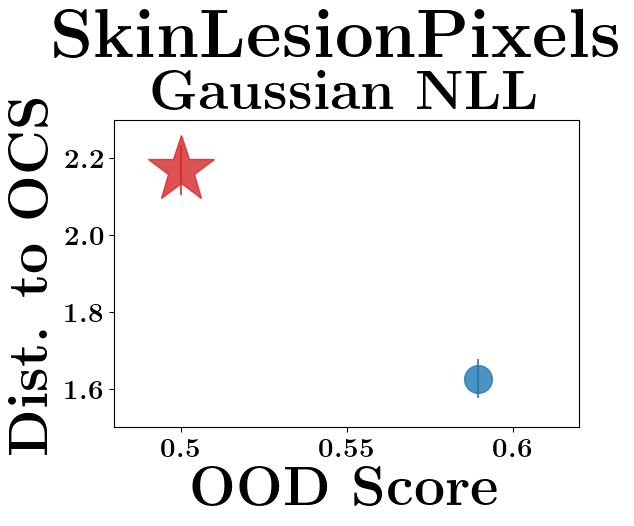

In [23]:
%matplotlib inline
import matplotlib as mpl
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
mpl.rcParams['text.latex.preamble'] = [r'\boldmath']

colors=["C3", "C0", "C1", "C2", "C4", "C5", "C6", "C7", "C8", "C9"]

# plt.rcParams["figure.figsize"] = np.array([6.4, 4.8])/4*3.5
fig, ax = plt.subplots(1, 1, figsize=(6, 4.8))#, gridspec_kw={'width_ratios': [1, 1.5]})



ax.errorbar([0.5], [train_kls_all.mean()], yerr=[train_kls_all.std()], fmt='*', markersize=50, zorder=100, alpha=0.8, color=colors[0])
ax.errorbar(np.e**np.mean(scores), [ood_kls_all.mean()], yerr=[ood_kls_all.std()], fmt='o', markersize=20, alpha=0.8, color=colors[1])

ax.set_xlabel(r"\textbf{OOD Score}", fontsize=40)

ax.set_ylabel(r"\textbf{Dist. to OCS}", fontsize=40)
ax.set_title(r"\textbf{Gaussian NLL}", fontsize=40)
# ytick_labels = [r"\textbf{"+str(0.1)+"}", r"\textbf{"+str(0.15)+"}", r"\textbf{"+str(0.2)+"}", r"\textbf{"+str(0.25)+"}", r"\textbf{"+str(0.3)+"}"]
ax.set_yticks([1.4+_*0.2 for _ in range(10)], [r"\textbf{%.1f}"%(1.4+_*0.2) for _ in range(10)], fontsize=20)
xticks_labels = [r"\textbf{"+str(0.5)+"}", r"\textbf{"+str(0.55)+"}",r"\textbf{"+str(0.6)+"}", r"\textbf{"+str(0.65)+"}", r"\textbf{"+str(0.7)+"}"]
ax.set_xticks([0.5+0.05*_ for _ in range(5)], xticks_labels, fontsize=20)
ax.set_ylim([1.5, 2.3])
ax.set_xlim([0.48, 0.62])


# set title to both subplots
fig.suptitle(r"\textbf{SkinLesionPixels}", fontsize=50)
# fig.tight_layout()
fig.subplots_adjust(top=0.75)
plt.show()


/home/katie/miniconda3/envs/cifar10/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  import sys


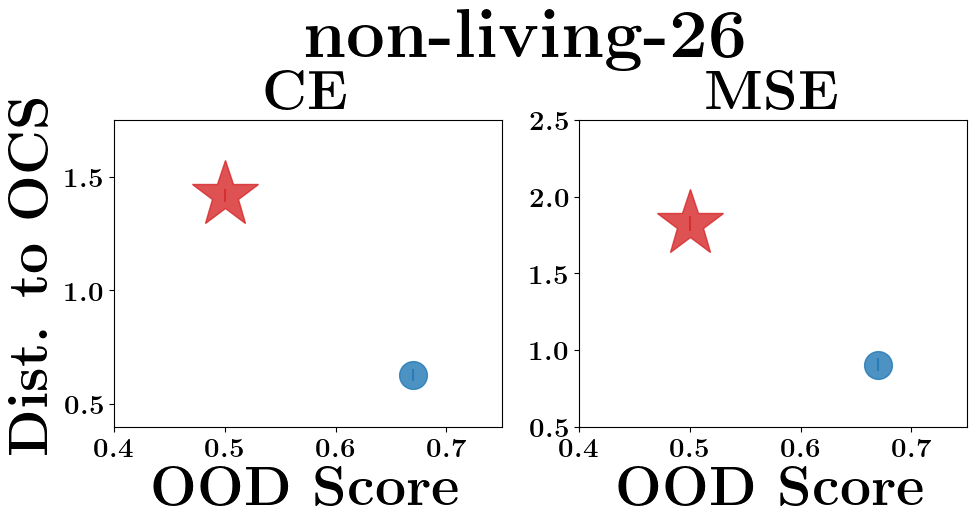

In [21]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
mpl.rcParams['text.latex.preamble'] = [r'\boldmath']

colors=["C3", "C0", "C1", "C2", "C4", "C5", "C6", "C7", "C8", "C9"]

fig, (ax2, ax1) = plt.subplots(1, 2, figsize=(5.5*2, 4.8))#, gridspec_kw={'width_ratios': [1, 1.5]})




ax1.errorbar([0.5], [1.824], yerr=[0.04827007354], fmt='*', markersize=50, zorder=100, alpha=0.8, color=colors[0])
ax1.errorbar([0.67], [0.906], yerr=[0.04037325848], fmt='o', markersize=20, alpha=0.8, color=colors[1])

ax1.set_xlabel(r"\textbf{OOD Score}", fontsize=40)

# ax1.set_ylabel(r"\textbf{Dist. to OCS}", fontsize=40)
ax1.set_title(r"\textbf{MSE}", fontsize=40)
# ytick_labels = [r"\textbf{"+str(0.1)+"}", r"\textbf{"+str(0.15)+"}", r"\textbf{"+str(0.2)+"}", r"\textbf{"+str(0.25)+"}", r"\textbf{"+str(0.3)+"}"]
ax1.set_yticks([0.5+_*0.5 for _ in range(10)], [r"\textbf{%.1f}"%(0.5+_*0.5) for _ in range(10)], fontsize=20)
xticks_labels = [r"\textbf{"+str(0.4)+"}", r"\textbf{"+str(0.5)+"}",r"\textbf{"+str(0.6)+"}", r"\textbf{"+str(0.7)+"}", r"\textbf{"+str(0.8)+"}"]
ax1.set_xticks([0.4+0.1*_ for _ in range(5)], xticks_labels, fontsize=20)
ax1.set_ylim([0.5, 2.5])
ax1.set_xlim([0.4, 0.75])


ax2.errorbar([0.5], [1.418], yerr=[0.02774887385], fmt='*', markersize=50, zorder=100, alpha=0.8, color=colors[0])
ax2.errorbar([0.67], [0.63], yerr=[0.02645751311], fmt='o', markersize=20, alpha=0.8, color=colors[1])


ax2.set_xlabel(r"\textbf{OOD Score}", fontsize=40)

ax2.set_ylabel(r"\textbf{Dist. to OCS}", fontsize=40)
ax2.set_title(r"\textbf{CE}", fontsize=40)
# ytick_labels = [r"\textbf{"+str(0.1)+"}", r"\textbf{"+str(0.15)+"}", r"\textbf{"+str(0.2)+"}", r"\textbf{"+str(0.25)+"}", r"\textbf{"+str(0.3)+"}"]
ax2.set_yticks([0.5+_*0.5 for _ in range(10)], [r"\textbf{%.1f}"%(.5+_*0.5) for _ in range(10)], fontsize=20)
xticks_labels = [r"\textbf{"+str(0.4)+"}", r"\textbf{"+str(0.5)+"}",r"\textbf{"+str(0.6)+"}", r"\textbf{"+str(0.7)+"}", r"\textbf{"+str(0.8)+"}"]
ax2.set_xticks([0.4+0.1*_ for _ in range(5)], xticks_labels, fontsize=20)
ax2.set_ylim([0.4, 1.75])
ax2.set_xlim([0.4, 0.75])


# set title to both subplots
fig.suptitle(r"\textbf{non-living-26}", fontsize=50)
# fig.tight_layout()
fig.subplots_adjust(top=0.75)

plt.show()

/home/katie/miniconda3/envs/cifar10/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  import sys


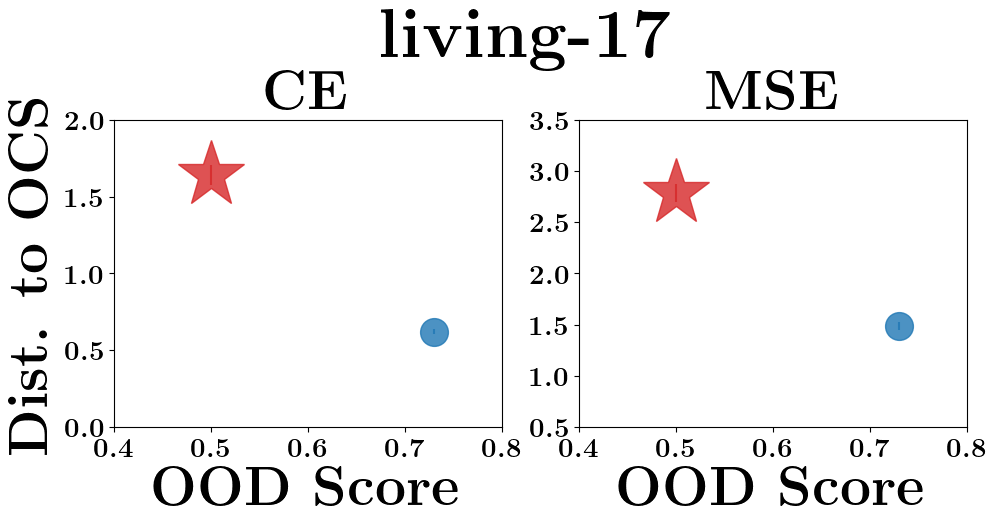

In [22]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
mpl.rcParams['text.latex.preamble'] = [r'\boldmath']

colors=["C3", "C0", "C1", "C2", "C4", "C5", "C6", "C7", "C8", "C9"]

fig, (ax2, ax1) = plt.subplots(1, 2, figsize=(5.5*2, 4.8))#, gridspec_kw={'width_ratios': [1, 1.5]})




ax1.errorbar([0.5], [2.786], yerr=[0.08706319544], fmt='*', markersize=50, zorder=100, alpha=0.8, color=colors[0])
ax1.errorbar([0.73], [1.486], yerr=[0.04037325848], fmt='o', markersize=20, alpha=0.8, color=colors[1])

ax1.set_xlabel(r"\textbf{OOD Score}", fontsize=40)

# ax1.set_ylabel(r"\textbf{Dist. to OCS}", fontsize=40)
ax1.set_title(r"\textbf{MSE}", fontsize=40)
# ytick_labels = [r"\textbf{"+str(0.1)+"}", r"\textbf{"+str(0.15)+"}", r"\textbf{"+str(0.2)+"}", r"\textbf{"+str(0.25)+"}", r"\textbf{"+str(0.3)+"}"]
ax1.set_yticks([0.5+_*0.5 for _ in range(10)], [r"\textbf{%.1f}"%(0.5+_*0.5) for _ in range(10)], fontsize=20)
xticks_labels = [r"\textbf{"+str(0.4)+"}", r"\textbf{"+str(0.5)+"}",r"\textbf{"+str(0.6)+"}", r"\textbf{"+str(0.7)+"}", r"\textbf{"+str(0.8)+"}"]
ax1.set_xticks([0.4+0.1*_ for _ in range(5)], xticks_labels, fontsize=20)
ax1.set_ylim([0.5, 3.5])
ax1.set_xlim([0.4, 0.8])


ax2.errorbar([0.5], [1.64], yerr=[0.06782329983], fmt='*', markersize=50, zorder=100, alpha=0.8, color=colors[0])
ax2.errorbar([0.73], [0.62], yerr=[0.01483239697], fmt='o', markersize=20, alpha=0.8, color=colors[1])


ax2.set_xlabel(r"\textbf{OOD Score}", fontsize=40)

ax2.set_ylabel(r"\textbf{Dist. to OCS}", fontsize=40)
ax2.set_title(r"\textbf{CE}", fontsize=40)
# ytick_labels = [r"\textbf{"+str(0.1)+"}", r"\textbf{"+str(0.15)+"}", r"\textbf{"+str(0.2)+"}", r"\textbf{"+str(0.25)+"}", r"\textbf{"+str(0.3)+"}"]
ax2.set_yticks([0.+_*0.5 for _ in range(10)], [r"\textbf{%.1f}"%(0.+_*0.5) for _ in range(10)], fontsize=20)
xticks_labels = [r"\textbf{"+str(0.4)+"}", r"\textbf{"+str(0.5)+"}",r"\textbf{"+str(0.6)+"}", r"\textbf{"+str(0.7)+"}", r"\textbf{"+str(0.8)+"}"]
ax2.set_xticks([0.4+0.1*_ for _ in range(5)], xticks_labels, fontsize=20)
ax2.set_ylim([0., 2])
ax2.set_xlim([0.4, 0.8])


# set title to both subplots
fig.suptitle(r"\textbf{living-17}", fontsize=50)
# fig.tight_layout()
fig.subplots_adjust(top=0.75)

plt.show()